# [BAF507] Team Project 

# Members
- FMBA: Vania Estrellita Soegiarto(20214863), Olga Khegay(20214847)
- IMMBA: Soojin Cho(20224189) Myokyung Han(20224230), Yunho Park(20224020)

## 1. Load Library and Data

In [1]:
!pip install dmba

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
# library for feature selection package
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from dmba import regressionSummary

no display found. Using non-interactive Agg backend


In [3]:
# library for data processing package
import pandas as pd
import numpy as np

# library for standardization data processing package
from sklearn.preprocessing import StandardScaler

# library for dealing time-serise data processing package
from pandas.tseries.offsets import YearEnd

# library for image processing package
import seaborn as sns

# library for linear modeling package
import statsmodels.api as sm
%matplotlib inline

In [4]:
dfs = []

### 1.1) load deepsearch data

In [5]:
def load_deepsearch_data(filepath, column):
    df = pd.read_excel(filepath)
    if '날짜' in df.columns:
            df['날짜'] = pd.to_datetime(df['날짜'])
            df = df.set_index('날짜')
    elif 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
    else :
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    df.columns = [column]
    
    return df

In [6]:
deepsearch_filenames = [
    'krw_cad_xr',
    'current_account_korea', 'current_account_canada',
    'gdp_korea', 'gdp_canada',
    'gdp_growth_korea', 'gdp_growth_canada',
    'cpi_korea', 'cpi_canada',
    'int_rate_korea', 
    'foreign_reserves_korea',
    'foreign_reserves_canada'   
]

In [7]:
for fname in deepsearch_filenames:
    print('Loading {}...'.format(fname))
    filepath = f'./proj_data/{fname}.xlsx'       
    df = load_deepsearch_data(filepath, fname)

    if fname in ['gdp_growth_korea', 'gdp_growth_canada', 'current_account_canada']:
        df[fname] = df[fname].rolling(4).sum()
    elif fname in ['current_account_korea']:
        df[fname] = df[fname].rolling(12).sum()

    dfs.append(df)
    
print('Deepsearch Data loading is completed')

Loading krw_cad_xr...
Loading current_account_korea...
Loading current_account_canada...
Loading gdp_korea...
Loading gdp_canada...
Loading gdp_growth_korea...
Loading gdp_growth_canada...
Loading cpi_korea...
Loading cpi_canada...
Loading int_rate_korea...
Loading foreign_reserves_korea...
Loading foreign_reserves_canada...
Deepsearch Data loading is completed


### 1.2) load world bank data

In [8]:
def load_world_bank_data(filepath, column, nation):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    df = df.loc[nation].to_frame()
    df = df.iloc[3:]
    df.dropna(inplace=True)
    df[nation] = df[nation].astype(float)
    df['date'] = pd.to_datetime(df.index)+YearEnd(0)
    df.set_index('date', inplace=True)
    df.columns = [column]
    dfs.append(df) 

In [9]:
load_world_bank_data('./proj_data/world_real_xr.xls',  'krw_real_xr', 'KOR')
load_world_bank_data('./proj_data/world_real_xr.xls',  'cad_real_xr', 'CAN')
load_world_bank_data('./proj_data/world_ppp_xr.xls',   'krw_ppp_xr', 'KOR')
load_world_bank_data('./proj_data/world_ppp_xr.xls',   'cad_ppp_xr', 'CAN')

### 1.3) load other data

In [10]:
def load_other_data(filepath, column):
    df = pd.read_excel(filepath)
    if '날짜' in df.columns:
            df['날짜'] = pd.to_datetime(df['날짜'])
            df = df.set_index('날짜')
    elif 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
    else :
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    df.columns = [column]
    
    return df

In [11]:
other_filenames = [
    'gold_price',
    'WTI_monthly',
    'trade_exim', 
    'int_rate_canada'
]

In [12]:
for fname in other_filenames:
    print('Loading {}...'.format(fname))
    filepath = f'./proj_data/{fname}.xlsx'
    df = pd.DataFrame()
    
    if fname in ['int_rate_canada'] :
        df = pd.read_excel(filepath, skiprows=14)
        df.dropna(axis=1, inplace=True)
        df.sort_values(by='Date', ascending=True, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.loc['1998-12-31':]
        df.columns = ['int_rate_canada']
        
    elif fname in ['WTI_monthly'] :
        df = pd.read_excel(filepath, skiprows = 2)
        df = df.set_index('Date')
        df.columns = ['oil_price']

                
    elif fname in ['trade_exim'] :
        df = pd.read_excel(filepath, skiprows = 4)
        df = df.drop(0)
        df['PRIOD'] = pd.to_datetime(df['PRIOD'])
        # rawdata 내 'PRIOD'는 Period를 의미함
        df = df.set_index('PRIOD')
        df['trade_balance'] = df['Trade Balance'].str.replace(',','')
        df = df['trade_balance'].astype(float)
    else :      
        df = load_other_data(filepath, fname)

        
    dfs.append(df)
    
print('Other Data loading is completed')

Loading gold_price...
Loading WTI_monthly...
Loading trade_exim...
Loading int_rate_canada...
Other Data loading is completed


### 1.4) merge whole data

In [13]:
df_merged = pd.concat(dfs, axis = 1)

In [14]:
df_merged.columns

Index(['krw_cad_xr', 'current_account_korea', 'current_account_canada',
       'gdp_korea', 'gdp_canada', 'gdp_growth_korea', 'gdp_growth_canada',
       'cpi_korea', 'cpi_canada', 'int_rate_korea', 'foreign_reserves_korea',
       'foreign_reserves_canada', 'krw_real_xr', 'cad_real_xr', 'krw_ppp_xr',
       'cad_ppp_xr', 'gold_price', 'oil_price', 'trade_balance',
       'int_rate_canada'],
      dtype='object')

In [15]:
df_merged.head()

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,foreign_reserves_korea,foreign_reserves_canada,krw_real_xr,cad_real_xr,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada
1946-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN


In [16]:
df_merged = df_merged.resample('M').last()

In [17]:
df_merged = df_merged.fillna(method='ffill')

In [18]:
df_merged.columns

Index(['krw_cad_xr', 'current_account_korea', 'current_account_canada',
       'gdp_korea', 'gdp_canada', 'gdp_growth_korea', 'gdp_growth_canada',
       'cpi_korea', 'cpi_canada', 'int_rate_korea', 'foreign_reserves_korea',
       'foreign_reserves_canada', 'krw_real_xr', 'cad_real_xr', 'krw_ppp_xr',
       'cad_ppp_xr', 'gold_price', 'oil_price', 'trade_balance',
       'int_rate_canada'],
      dtype='object')

## 2. Data Preprocessing

### 2.1) Data Preprocessing for Currency Returns

In [19]:
df_merged['ann_ret'] = df_merged['krw_cad_xr'].pct_change(periods=12)*100

In [20]:
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

In [21]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_real_xr,cad_real_xr,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,0.727463,1.186103,840.991702,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,0.727463,1.186103,840.991702,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,0.727463,1.186103,840.991702,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,0.727463,1.186103,840.991702,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,0.727463,1.186103,840.991702,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,0.698660,0.928844,824.604924,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,0.698660,0.928844,824.604924,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,0.698660,0.928844,824.604924,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,0.698660,0.928844,824.604924,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN


### 2.2) Data Preprocessing for PPP XR

$$
    \text{PPP XR} = \frac{\frac{{P(KRW)}}{P(USD)}} {\frac{{P(CAD)}}{P(USD)}} = \frac{{P(KRW)}}{P(CAD)}
$$

In [22]:
df_merged['krw_cad_ppp_xr'] = df_merged['krw_ppp_xr']/ df_merged['cad_ppp_xr']

### 2.3) Data Preprocessing for KRW_CAD_REAL_XR

In [23]:
# world bank의 real XR 기준으로 KRW/CAD의 real XR 계산 >> KRW_CAD_REAL_XR
# 추후 계산할 New Real XR의 Validation을 위한 Data Preprocessing
df_merged['krw_cad_real_xr'] = df_merged['krw_real_xr']/df_merged['cad_real_xr']

In [24]:
df_merged.loc[['2009-12-31']]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr
2009-12-31,1106.99,33087.6,-40775.27,943941.9,1376509.2,5.1,-1.8,98.04,98.57,3.48,...,828.420848,1.202244,1096.98,74.47,16663.0,3.615,6.614595,2.861814,689.06216,0.616844


In [25]:
df_merged['krw_cad_ppp_xr'] = df_merged['krw_cad_ppp_xr'].fillna(method='ffill')
df_merged['krw_cad_real_xr'] = df_merged['krw_cad_real_xr'].fillna(method='ffill')

In [26]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,840.991702,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,840.991702,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,840.991702,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,840.991702,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,840.991702,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,824.604924,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,824.604924,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,824.604924,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,824.604924,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182


### 2.4) Data Preprocessing for New Real XR

$$
    \text{Real XR} = \frac{S^{PPP}}{S}
$$

In [27]:
## New Real XR calculate
df_merged['new_real_xr'] = \
    df_merged['krw_cad_ppp_xr']/df_merged['krw_cad_xr']

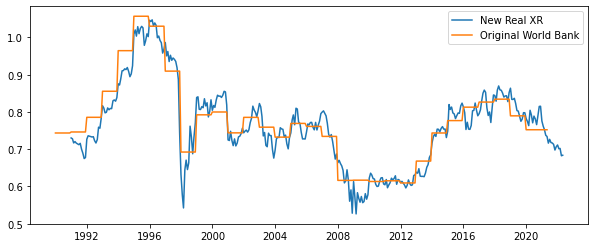

In [28]:
# let's draw a gragh with New Real XR and Original World Bank data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)

plt.plot(df_merged['new_real_xr'], label = 'New Real XR')
plt.plot(df_merged['krw_cad_real_xr'].shift(-12), label = 'Original World Bank')
plt.legend()
plt.show()

In [29]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322,0.618573
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322,0.603983
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322,0.610031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182,0.711307
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182,0.701143
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182,0.701991
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182,0.682317


### 2.5) Data Preprocessing for Current Account relative to GDP

In [30]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea']/df_merged['gdp_korea']*100

In [31]:
df_merged['ca_gdp_canada'] = df_merged['current_account_canada']/df_merged['gdp_canada']*100

In [32]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486,2.443082,-3.596181
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322,0.618573,2.322180,-3.596181
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467,2.467915,-3.596181
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322,0.603983,2.174628,-3.539929
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322,0.610031,1.882503,-3.539929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182,0.711307,5.518208,-0.063136
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182,0.701143,5.197730,-0.063136
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182,0.701991,5.197730,-0.063136
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182,0.682317,5.197730,-0.063136


In [33]:
df_merged.loc['2009-12-31':][['ca_gdp_korea', 'ca_gdp_canada']].head()

,ca_gdp_korea,ca_gdp_canada
2009-12-31,3.505258,-2.962223
2010-01-31,3.298445,-2.962223
2010-02-28,2.733219,-2.962223
2010-03-31,2.217414,-3.442037
2010-04-30,1.969274,-3.442037


### 2.6) Data Preprocessing for GDP Growth

In [34]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods=12)*100

In [35]:
df_merged['gdp_growth_canada2'] = df_merged['gdp_canada'].pct_change(periods=12)*100

In [36]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea2,gdp_growth_canada2
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486,2.443082,-3.596181,21.200998,17.496149
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,3.274,2.638982,0.920251,688.310637,0.613322,0.618573,2.322180,-3.596181,21.200998,17.496149
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467,2.467915,-3.596181,21.200998,17.496149
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,3.353,2.704554,0.160580,688.310637,0.613322,0.603983,2.174628,-3.539929,21.200998,17.496149
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,3.213,1.533367,2.478907,688.310637,0.613322,0.610031,1.882503,-3.539929,21.200998,17.496149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,1.430,9.060120,NaN,661.949395,0.752182,0.711307,5.518208,-0.063136,0.000000,0.000000
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,1.770,8.644618,NaN,661.949395,0.752182,0.701143,5.197730,-0.063136,0.000000,0.000000
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,1.849,7.253267,NaN,661.949395,0.752182,0.701991,5.197730,-0.063136,0.000000,0.000000
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,2.401,8.068217,NaN,661.949395,0.752182,0.682317,5.197730,-0.063136,0.000000,0.000000


In [37]:
df_merged.loc[['2018-12-31', '2019-12-31']][['gdp_canada', 'gdp_growth_korea2','gdp_growth_canada2']]

,gdp_canada,gdp_growth_korea2,gdp_growth_canada2
2018-12-31,1716179.4,5.953397,4.034536
2019-12-31,1736346.3,-4.556310,1.175104


### 2.7) Data Preprocessing for Inflation & Interest rate differential

In [38]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods=12) *100

In [39]:
df_merged['infl_canada'] = df_merged['cpi_canada'].pct_change(periods=12) *100

In [40]:
df_merged['infl_diff'] = df_merged['infl_korea']- df_merged['infl_canada']

In [41]:
df_merged['int_rate_diff'] = df_merged['int_rate_korea']- df_merged['int_rate_canada']

In [42]:
df_merged['2008-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea2,gdp_growth_canada2,infl_korea,infl_canada,infl_diff,int_rate_diff
2008-12-31,1038.31,1753.0,3177.94,1047339.0,1552864.1,-1.6,0.1,95.37,97.28,3.260,...,0.616281,0.613038,0.167377,0.204650,-10.683404,5.71643,4.138458,1.164725,2.973733,0.572
2009-01-31,1116.50,2617.5,3177.94,1047339.0,1552864.1,-1.6,0.1,95.46,97.02,2.530,...,0.616281,0.570106,0.249919,0.204650,-10.683404,5.71643,3.749592,1.073028,2.676564,-0.534
2009-02-28,1209.49,9865.7,3177.94,1047339.0,1552864.1,-1.9,0.1,96.15,97.71,2.540,...,0.616281,0.526274,0.941978,0.204650,-10.683404,5.71643,4.103508,1.422047,2.681461,-0.592
2009-03-31,1091.38,14679.2,-6845.27,1047339.0,1552864.1,-1.9,-2.3,96.84,97.88,2.700,...,0.616281,0.583228,1.401571,-0.440816,-10.683404,5.71643,3.883287,1.241208,2.642079,-0.080
2009-04-30,1119.83,20204.9,-6845.27,1047339.0,1552864.1,-1.9,-2.3,97.09,97.80,2.530,...,0.616281,0.568411,1.929165,-0.440816,-10.683404,5.71643,3.573715,0.359159,3.214556,-0.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,0.752182,0.711307,5.518208,-0.063136,0.000000,0.00000,3.782526,4.806307,-1.023780,-0.080
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,0.752182,0.701143,5.197730,-0.063136,0.000000,0.00000,3.660310,5.140738,-1.480429,-0.307
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,0.752182,0.701991,5.197730,-0.063136,0.000000,0.00000,3.139891,5.685058,-2.545167,-0.346
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,0.752182,0.682317,5.197730,-0.063136,0.000000,0.00000,2.990908,5.156015,-2.165107,-0.586


### 2.8) Data Preprocessing for Foreign Reserves

In [43]:
df_merged['reserves_to_gdp_korea'] = df_merged['foreign_reserves_korea']/df_merged['gdp_korea']/1000*100
df_merged['reserves_growth_korea'] = df_merged['foreign_reserves_korea'].pct_change(periods=12)*100

In [44]:
df_merged['reserves_to_gdp_canada'] = df_merged['foreign_reserves_canada']/df_merged['gdp_canada']/1000*100
df_merged['reserves_growth_canada'] = df_merged['foreign_reserves_canada'].pct_change(periods=12)*100

### 2.9) Data Preprocessing for Gold Price

In [45]:
df_merged['gold_growth'] = df_merged['gold_price'].pct_change(periods=12) * 100

### 2.11) Data Preprocessing for Trade Balance

In [46]:
df_merged['trade_balance_growth'] = df_merged['trade_balance'].pct_change(periods=12)*100

In [47]:
#Scaling for trade balance data
ss = StandardScaler() 
df_merged['trade_balance_scaled'] = ss.fit_transform(df_merged[['trade_balance']])                

In [48]:
df_merged['trade_balance_scaled'].max()

6.505067678656895

### 2.12) Data Preprocessing for Oil Price

In [49]:
df_merged['oil_growth'] = df_merged['oil_price'].pct_change(periods=12) * 100

## 3. Use OLS

### 3.1) Dataset slicing for better prediction

#### Plot a time-series chart of XR return, and slicing the data after 2008 financial crisis

In [50]:
df_20s = df_merged.loc['2000-01-01':].copy()

In [51]:
event = df_20s.loc['2008-01-01':].iloc[0]

In [52]:
using_data = df_20s.loc['2009-06-30':].iloc[0]

In [53]:
bbox = dict(boxstyle="round", fc="0.8")

In [54]:
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

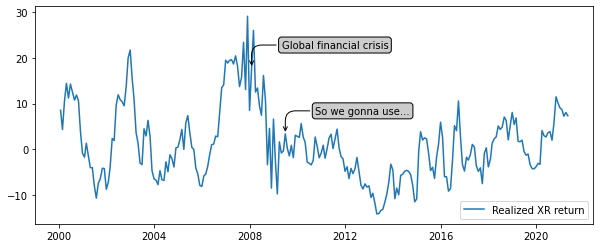

In [55]:
plt.rcParams['figure.figsize'] = (10,4)
plt.plot(df_20s['F12.ann_ret'], label = 'Realized XR return')

plt.annotate("Global financial crisis", xy=(event.name, event['F12.ann_ret']),
             xytext=(30,20),
             textcoords = 'offset points',
             arrowprops=arrowprops, bbox=bbox)

plt.annotate("So we gonna use...", xy=(using_data.name, using_data['F12.ann_ret']),
             xytext=(30,20),
             textcoords = 'offset points',
             arrowprops=arrowprops, bbox=bbox)

plt.legend(loc='lower right')
plt.show()

In [56]:
# Volatility of XR return is highest at Global financial crisis in 2008. Therefore we slice the data after this.  
# dataset = df_merged.loc['2008-12-31':].copy()
dataset = df_merged.loc['2009-12-31':].copy()

In [57]:
dataset.head()

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,infl_diff,int_rate_diff,reserves_to_gdp_korea,reserves_growth_korea,reserves_to_gdp_canada,reserves_growth_canada,gold_growth,trade_balance_growth,trade_balance_scaled,oil_growth
2009-12-31,1106.99,33087.6,-40775.27,943941.9,1376509.2,5.1,-1.8,98.04,98.57,3.48,...,1.473553,-0.135,28.602898,34.176601,0.003949,23.899070,24.367099,-117.874728,0.001064,81.104086
2010-01-31,1084.13,31135.4,-40775.27,943941.9,1376509.2,5.1,-1.8,98.82,98.83,3.22,...,1.654204,-0.130,28.994749,35.665819,0.004139,33.345035,16.527456,9.717199,-0.640119,87.796691
2010-02-28,1092.42,25800.0,-40775.27,943941.9,1376509.2,7.0,-1.8,99.02,99.26,3.07,...,1.398593,-0.325,28.673345,34.299363,0.004166,32.757623,18.599839,-191.594431,-0.059641,95.420824
2010-03-31,1109.61,20931.1,-47379.96,943941.9,1376509.2,7.0,1.7,99.22,99.26,2.70,...,1.047772,-0.866,28.850405,31.981403,0.004117,30.201728,21.090988,-165.960947,0.049905,69.378390
2010-04-30,1111.28,18588.8,-47379.96,943941.9,1376509.2,7.0,1.7,99.62,99.60,2.65,...,0.765339,-1.000,29.543500,31.248152,0.004130,33.359140,32.743751,-272.615917,0.531761,69.768379


In [58]:
X_cols = ['new_real_xr', 
          'ca_gdp_korea', 'ca_gdp_canada',
          'gdp_growth_korea', 'gdp_growth_canada', 
          'infl_diff', 'int_rate_diff', 
          'reserves_to_gdp_korea' , 'reserves_growth_korea',
          'reserves_to_gdp_canada' , 'reserves_growth_canada',
          'gold_growth', 'oil_growth',
          'trade_balance_growth', 'trade_balance_scaled']

In [59]:
dataset[['F12.ann_ret', *X_cols]].loc['2008-12-31':].head(15)

,F12.ann_ret,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea,gdp_growth_canada,infl_diff,int_rate_diff,reserves_to_gdp_korea,reserves_growth_korea,reserves_to_gdp_canada,reserves_growth_canada,gold_growth,oil_growth,trade_balance_growth,trade_balance_scaled
2009-12-31,2.861814,0.622465,3.505258,-2.962223,5.1,-1.8,1.473553,-0.135,28.602898,34.176601,0.003949,23.899070,24.367099,81.104086,-117.874728,0.001064
2010-01-31,2.638982,0.635590,3.298445,-2.962223,5.1,-1.8,1.654204,-0.130,28.994749,35.665819,0.004139,33.345035,16.527456,87.796691,9.717199,-0.640119
2010-02-28,5.635195,0.630767,2.733219,-2.962223,7.0,-1.8,1.398593,-0.325,28.673345,34.299363,0.004166,32.757623,18.599839,95.420824,-191.594431,-0.059641
2010-03-31,2.704554,0.620995,2.217414,-3.442037,7.0,1.7,1.047772,-0.866,28.850405,31.981403,0.004117,30.201728,21.090988,69.378390,-165.960947,0.049905
2010-04-30,1.533367,0.620062,1.969274,-3.442037,7.0,1.7,0.765339,-1.000,29.543500,31.248152,0.004130,33.359140,32.743751,69.768379,-272.615917,0.531761
2010-05-31,-2.756075,0.605583,2.427035,-3.442037,7.6,1.7,1.307527,-0.604,28.626872,19.162781,0.004070,24.865166,24.216181,24.919532,-214.757274,-1.286989
2010-06-30,-3.007087,0.599904,2.393813,-3.729323,7.6,3.3,1.739316,0.007,29.050380,18.333072,0.004024,24.027137,34.093902,8.184951,-863.122712,-1.100629
2010-07-31,-3.350104,0.600841,2.559246,-3.729323,7.6,3.3,0.699300,0.007,30.294009,20.398391,0.004164,26.196768,23.794549,18.971161,-128.398738,0.026522
2010-08-31,-2.391926,0.614307,2.833469,-3.729323,5.8,3.3,0.935131,0.353,30.229945,16.253084,0.004208,8.127532,31.140992,7.811400,-104.525476,-0.131092
2010-09-30,2.716605,0.622932,3.046385,-4.199545,5.8,3.6,1.496660,0.082,30.698416,13.973785,0.004326,2.379561,29.854123,8.399366,-142.580941,-0.071278


In [60]:
df = dataset[['F12.ann_ret', *X_cols]].copy()
df = df.dropna()

In [61]:
X_data = df[X_cols].copy()
Y = df['F12.ann_ret']

### 3.2) Put all the variables and check results

In [62]:
X = sm.add_constant(X_data)

/Users/boysbeanxious/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
model = sm.OLS(Y,X)

In [64]:
results = model.fit()

In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     13.32
Date:                Sun, 17 Apr 2022   Prob (F-statistic):           3.51e-19
Time:                        13:12:13   Log-Likelihood:                -364.15
No. Observations:                 137   AIC:                             760.3
Df Residuals:                     121   BIC:                             807.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -63.7027     13.685     -4.655      0.000     -90.795     -36.610
new_real_xr               67.3147     11.358      5.927      0.000      44.829      89.800
ca_gdp_korea              -0.9176      0.379     -2.419      0.017      -1.668      -0.167
ca_gdp_canada             -0.4877      0.924     -0.528      0.598      -2.317       1.341
gdp_growth_korea          -0.1101      0.453     -0.243      0.808      -1.006       0.786
gdp_growth_canada         -0.2444      0.201     -1.217      0.226      -0.642       0.153
infl_diff                  0.4069      0.551      0.738      0.462      -0.684       1.498
int_rate_diff              1.5542      1.217      1.277      0.204      -0.856       3.964
reserves_to_gdp_korea      0.7750      0.422      1.839      0.068      -0.059       1.610
reserves_growth_korea      0.2628      0.149      1.759      0.081      -0.033       0.559
reserves_to_gdp_canada -1197.7259   1386.804     -0.864      0.389   -3943.271    1547.819
reserves_growth_canada    -0.1598      0.097     -1.639      0.104      -0.353       0.033
gold_growth                0.1383      0.037      3.731      0.000       0.065       0.212
oil_growth                 0.0198      0.012      1.622      0.107      -0.004       0.044
trade_balance_growth       0.0003      0.000      1.246      0.215      -0.000       0.001
trade_balance_scaled       0.2633      0.308      0.854      0.395      -0.347       0.874
==============================================================================
Omnibus:                        6.639   Durbin-Watson:                   0.582
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                4.795
Skew:                           0.328   Prob(JB):                       0.0909
Kurtosis:                       2.360   Cond. No.                     6.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3) Check correlation between variables

In [66]:
df_corr = X_data.corr()

In [67]:
def onetozero(x):
#     print(x)
    return np.where(x==1, 0, abs(x))

In [68]:
df_corr = df_corr.apply(lambda x: onetozero(x))

In [69]:
# corr이 가장 높은 컬럼
print('The most highest correlation coefficient columne is [{}] and [{}]'.format(df_corr.max().sort_values(ascending=False).index[0]
                                                                         , df_corr[df_corr.max().sort_values(ascending=False).index[0]].idxmax())
)

print('The most highest correlation coefficient value is {:.4f}'.format(df_corr.max().sort_values(ascending=False)[0]))

The most highest correlation coefficient columne is [new_real_xr] and [reserves_to_gdp_canada]
The most highest correlation coefficient value is 0.7902


In [70]:
# corr이 두번째로 높은 컬럼
print('The second highest correlation coefficient columne is [{}] and [{}]'.format(df_corr.max().sort_values(ascending=False).index[1]
                                                                         , df_corr[df_corr.max().sort_values(ascending=False).index[1]].idxmax())
)

print('The second highest correlation coefficient value is {:.4f}'.format(df_corr.max().sort_values(ascending=False)[1]))

The second highest correlation coefficient columne is [reserves_to_gdp_canada] and [new_real_xr]
The second highest correlation coefficient value is 0.7902


In [71]:
# corr이 세번째로 높은 컬럼
print('The third highest correlation coefficient columne is [{}] and [{}]'.format(df_corr.max().sort_values(ascending=False).index[2]
                                                                         , df_corr[df_corr.max().sort_values(ascending=False).index[2]].idxmax())
)

print('The third highest correlation coefficient value is {:.4f}'.format(df_corr.max().sort_values(ascending=False)[2]))

The third highest correlation coefficient columne is [reserves_to_gdp_korea] and [reserves_growth_korea]
The third highest correlation coefficient value is 0.7391


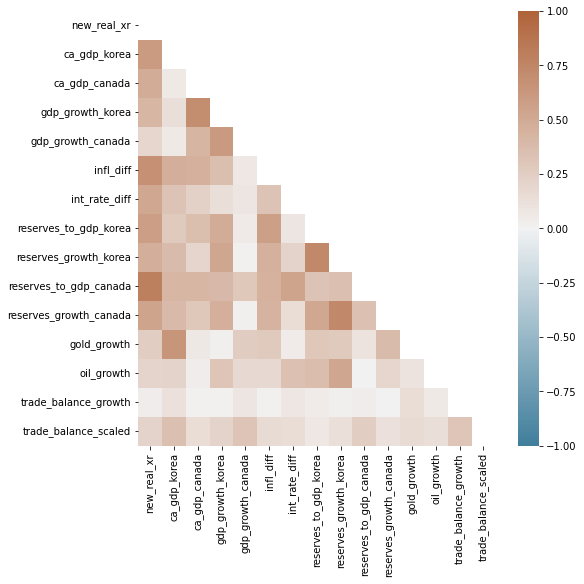

In [72]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
plt.rcParams['figure.figsize']  = (8, 8)
sns.heatmap(df_corr, cmap=cmap, mask = mask, vmin=-1, vmax=1)
plt.show()

### 3.4) Reduce the predictors according to correlation scores and standard error

In [73]:
X_data = X_data.drop(['reserves_to_gdp_canada'], axis=1) 
X_cols = X_data.columns.tolist()
X_cols

['new_real_xr',
 'ca_gdp_korea',
 'ca_gdp_canada',
 'gdp_growth_korea',
 'gdp_growth_canada',
 'infl_diff',
 'int_rate_diff',
 'reserves_to_gdp_korea',
 'reserves_growth_korea',
 'reserves_growth_canada',
 'gold_growth',
 'oil_growth',
 'trade_balance_growth',
 'trade_balance_scaled']

### 3.5) Forward/Backword selection to reduce the remaining predictors 

In [74]:
def train_model(variables):
    if len(variables) == 0: 
        return None
    model = LinearRegression() 
    model.fit(X_data[variables], Y)
    return model

def score_model(model, variables): 
    if len(variables) == 0:
        return AIC_score(Y, [Y.mean()] * len(Y), model, df=1)
    return AIC_score(Y, model.predict(X_data[variables]), model)

foward_best_model, foward_best_variables = forward_selection(X_cols, train_model,score_model, verbose=True)
regressionSummary(Y, foward_best_model.predict(X_data[foward_best_variables]))


Variables: new_real_xr, ca_gdp_korea, ca_gdp_canada, gdp_growth_korea, gdp_growth_canada, infl_diff, int_rate_diff, reserves_to_gdp_korea, reserves_growth_korea, reserves_growth_canada, gold_growth, oil_growth, trade_balance_growth, trade_balance_scaled
Start: score=865.91, constant
Step: score=840.86, add gold_growth
Step: score=787.82, add new_real_xr
Step: score=769.67, add reserves_growth_korea
Step: score=760.24, add reserves_growth_canada
Step: score=758.24, add int_rate_diff
Step: score=757.48, add trade_balance_growth
Step: score=756.88, add ca_gdp_korea
Step: score=755.88, add reserves_to_gdp_korea
Step: score=754.43, add gdp_growth_canada
Step: score=754.43, add None

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 3.5049
            Mean Absolute Error (MAE) : 2.9552
          Mean Percentage Error (MPE) : 54.5895
Mean Absolute Percentage Error (MAPE) : 121.6839


In [75]:
def train_model(variables):
    model = LinearRegression() 
    model.fit(X_data[variables], Y) 
    return model

def score_model(model, variables):
    return AIC_score(Y, model.predict(X_data[variables]), model)

allVariables = X_cols
backward_best_model, backward_best_variables = backward_elimination(allVariables, train_model,score_model, verbose=True) 
regressionSummary(Y, backward_best_model.predict(X_data[backward_best_variables]))

Variables: new_real_xr, ca_gdp_korea, ca_gdp_canada, gdp_growth_korea, gdp_growth_canada, infl_diff, int_rate_diff, reserves_to_gdp_korea, reserves_growth_korea, reserves_growth_canada, gold_growth, oil_growth, trade_balance_growth, trade_balance_scaled
Start: score=761.14
Step: score=759.14, remove gdp_growth_korea
Step: score=757.43, remove infl_diff
Step: score=756.02, remove ca_gdp_canada
Step: score=754.59, remove trade_balance_scaled
Step: score=754.43, remove oil_growth
Step: score=754.43, remove None

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 3.5049
            Mean Absolute Error (MAE) : 2.9552
          Mean Percentage Error (MPE) : 54.5895
Mean Absolute Percentage Error (MAPE) : 121.6839


In [76]:
# forward와 backward 의 best variables 교집합 
set1 = set(backward_best_variables)
set2 = set(foward_best_variables)

print(set1.intersection(set2))

final_column = set1.intersection(set2)

{'trade_balance_growth', 'new_real_xr', 'int_rate_diff', 'ca_gdp_korea', 'gold_growth', 'reserves_growth_korea', 'reserves_growth_canada', 'gdp_growth_canada', 'reserves_to_gdp_korea'}


In [77]:
# 위 결과에서 유의미한 변수 넣기
selected_col = final_column

In [78]:
final_df = dataset[['F12.ann_ret', *selected_col]].copy()
final_df = df.dropna()

In [79]:
final_df

,F12.ann_ret,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea,gdp_growth_canada,infl_diff,int_rate_diff,reserves_to_gdp_korea,reserves_growth_korea,reserves_to_gdp_canada,reserves_growth_canada,gold_growth,oil_growth,trade_balance_growth,trade_balance_scaled
2009-12-31,2.861814,0.622465,3.505258,-2.962223,5.1,-1.8,1.473553,-0.135,28.602898,34.176601,0.003949,23.899070,24.367099,81.104086,-117.874728,0.001064
2010-01-31,2.638982,0.635590,3.298445,-2.962223,5.1,-1.8,1.654204,-0.130,28.994749,35.665819,0.004139,33.345035,16.527456,87.796691,9.717199,-0.640119
2010-02-28,5.635195,0.630767,2.733219,-2.962223,7.0,-1.8,1.398593,-0.325,28.673345,34.299363,0.004166,32.757623,18.599839,95.420824,-191.594431,-0.059641
2010-03-31,2.704554,0.620995,2.217414,-3.442037,7.0,1.7,1.047772,-0.866,28.850405,31.981403,0.004117,30.201728,21.090988,69.378390,-165.960947,0.049905
2010-04-30,1.533367,0.620062,1.969274,-3.442037,7.0,1.7,0.765339,-1.000,29.543500,31.248152,0.004130,33.359140,32.743751,69.768379,-272.615917,0.531761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,9.060120,0.775752,4.611527,-1.716880,-1.6,-2.4,-0.197384,0.066,27.052888,8.385671,0.005496,6.015452,25.116822,-21.476286,-387.125685,0.904102
2021-01-31,8.644618,0.761754,4.981117,-1.716880,-1.6,-2.4,-0.384737,-0.219,27.030273,8.073945,0.005415,3.047229,16.265826,-9.596662,-13.370919,1.168981
2021-02-28,7.253267,0.752908,5.082912,-1.716880,1.3,-2.4,0.042474,-0.684,27.325150,9.381409,0.005246,-1.419468,9.355549,16.818362,4878.891470,1.306285
2021-03-31,8.068217,0.737367,5.196197,-0.963103,1.3,1.1,-0.655476,-0.870,27.237837,11.472098,0.005067,-3.164925,8.276164,113.385827,-30.430291,0.866125


### 3.5) OLS(Ordinary Least Square) Regression

In [80]:
df_X = final_df[selected_col].copy()
df_Y = final_df['F12.ann_ret']

In [81]:
df_X.head()

,trade_balance_growth,new_real_xr,int_rate_diff,ca_gdp_korea,gold_growth,reserves_growth_korea,reserves_growth_canada,gdp_growth_canada,reserves_to_gdp_korea
2009-12-31,-117.874728,0.622465,-0.135,3.505258,24.367099,34.176601,23.899070,-1.8,28.602898
2010-01-31,9.717199,0.635590,-0.130,3.298445,16.527456,35.665819,33.345035,-1.8,28.994749
2010-02-28,-191.594431,0.630767,-0.325,2.733219,18.599839,34.299363,32.757623,-1.8,28.673345
2010-03-31,-165.960947,0.620995,-0.866,2.217414,21.090988,31.981403,30.201728,1.7,28.850405
2010-04-30,-272.615917,0.620062,-1.000,1.969274,32.743751,31.248152,33.359140,1.7,29.543500


In [82]:
df_Y.head()

2009-12-31    2.861814
2010-01-31    2.638982
2010-02-28    5.635195
2010-03-31    2.704554
2010-04-30    1.533367
Freq: M, Name: F12.ann_ret, dtype: float64

In [83]:
X = sm.add_constant(df_X)

/Users/boysbeanxious/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [84]:
Y = final_df['F12.ann_ret']

In [85]:
model = sm.OLS(Y,X)

In [86]:
results = model.fit()

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     22.20
Date:                Sun, 17 Apr 2022   Prob (F-statistic):           3.16e-22
Time:                        13:12:15   Log-Likelihood:                -366.21
No. Observations:                 137   AIC:                             752.4
Df Residuals:                     127   BIC:                             781.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -58.9531     12.867     -4.582      0.000     -84.415     -33.491
trade_balance_growth       0.0003      0.000      1.478      0.142      -0.000       0.001
new_real_xr               56.6168      7.544      7.504      0.000      41.688      71.546
int_rate_diff              1.6816      0.941      1.786      0.076      -0.181       3.545
ca_gdp_korea              -0.8998      0.355     -2.533      0.013      -1.603      -0.197
gold_growth                0.1261      0.033      3.816      0.000       0.061       0.192
reserves_growth_korea      0.3794      0.111      3.403      0.001       0.159       0.600
reserves_growth_canada    -0.2201      0.079     -2.788      0.006      -0.376      -0.064
gdp_growth_canada         -0.2283      0.127     -1.799      0.074      -0.479       0.023
reserves_to_gdp_korea      0.7129      0.385      1.854      0.066      -0.048       1.474
==============================================================================
Omnibus:                        5.661   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                3.676
Skew:                           0.233   Prob(JB):                        0.159
Kurtosis:                       2.347   Cond. No.                     6.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.6) Results analysis

In [88]:
last_obs = dataset.iloc[-1]

In [89]:
last_xr = last_obs['krw_cad_xr']
last_year_xr = last_obs['new_real_xr']

In [90]:
last_xr

968.06

In [91]:
last_year_xr

0.6837896357754619

In [92]:
import matplotlib.pyplot as plt

In [93]:
plt.rcParams['figure.figsize']  = (10, 4)

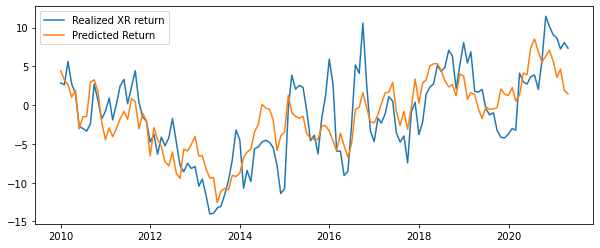

In [94]:
plt.plot(Y, label = 'Realized XR return')
plt.plot(Y.index, results.predict(), label='Predicted Return')
plt.legend()
plt.savefig(f'./Realized_Predicted2.jpg', dpi=300)
plt.show()

In [95]:
plt.rcParams['figure.figsize']  = (6, 6)

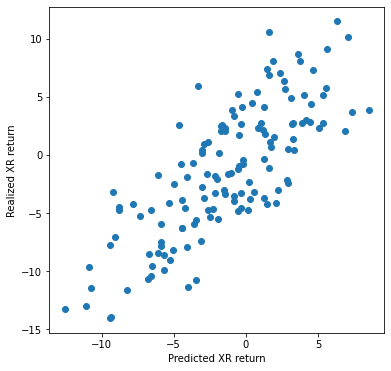

In [96]:
plt.scatter(results.predict(), Y)
plt.xlabel('Predicted XR return')
plt.ylabel('Realized XR return')
plt.show()

## 3.7) XR Forecast

In [97]:
dataset.tail(3)

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,infl_diff,int_rate_diff,reserves_to_gdp_korea,reserves_growth_korea,reserves_to_gdp_canada,reserves_growth_canada,gold_growth,trade_balance_growth,trade_balance_scaled,oil_growth
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,-2.545167,-0.346,28.192654,3.174745,0.006479,23.504199,10.089156,-89.648299,-0.010036,55.216802
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,-2.165107,-0.586,28.192654,3.505480,0.006479,27.874063,11.786545,-85.216671,-0.010036,74.073480
2022-04-30,968.06,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.852,...,-1.859647,-0.549,28.192654,2.090744,0.006479,26.565523,7.905581,-187.566257,-0.010036,75.793908


In [98]:
last_obs = dataset.iloc[-1]

In [99]:
last_xr = last_obs['krw_cad_xr']

In [100]:
last_xr

968.06

In [101]:
# exog = exogeneous variables
exog = last_obs[selected_col]

In [102]:
exog

trade_balance_growth     -187.566257
new_real_xr                 0.683790
int_rate_diff              -0.549000
ca_gdp_korea                5.197730
gold_growth                 7.905581
reserves_growth_korea       2.090744
reserves_growth_canada     26.565523
gdp_growth_canada           3.900000
reserves_to_gdp_korea      28.192654
Name: 2022-04-30 00:00:00, dtype: float64

In [103]:
exog = [1, *exog]

In [104]:
pred_ret = results.predict(exog=exog)

In [105]:
pred_xr = last_xr*(1+pred_ret[0]/100)

In [106]:
print('Predicted XR return : {:.2f}%'.format(pred_ret[0]))

Predicted XR return : -10.75%


In [107]:
print('Predicted XR {:.2f} to : {:.2f}'.format(last_xr, pred_xr))

Predicted XR 968.06 to : 864.00


In [108]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [109]:
for alpha in [.05, .25, .50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha=alpha)
    
    print('Confidence interval at alpha {:.2f} : {:.2f}  ~ {:.2f}'.format( 
        alpha, 
        last_xr*(1+iv_l[0]/100), 
        last_xr*(1+iv_u[0]/100)))

Confidence interval at alpha 0.05 : 778.70  ~ 949.29
Confidence interval at alpha 0.25 : 814.19  ~ 913.81
Confidence interval at alpha 0.50 : 834.84  ~ 893.16
